In [1]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
data <- read.csv("sp500_2023_2024.csv")

In [3]:
head(data)

,tic,datadate,conm,exchg,sic,cshtrd,prccd,prchd,prcld,prcod,gvkey
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,PNW,03/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,1442534,74.63,76.4125,73.380,76.25,1075
2,PNW,04/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,954218,75.39,76.0950,74.630,75.10,1075
3,PNW,05/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,994775,73.65,75.0950,73.305,74.88,1075
4,PNW,06/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,729808,75.46,76.0200,74.480,74.49,1075
5,PNW,09/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,656127,75.55,76.4800,75.240,75.24,1075
6,PNW,10/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,763254,75.65,75.6950,74.880,75.31,1075


## A2_Questions

In [4]:
# number of unique tickers
length(unique(data$tic))
print(paste("There are", length(unique(data$tic)), "unique tickers"))

[1] 502

[1] "There are 502 unique tickers"


In [5]:
# number of unique companies
length(unique(data$conm))
print(paste("There are", length(unique(data$conm)), "unique companies"))

[1] 499

[1] "There are 499 unique companies"


In [6]:
# top 5 companies by largest mean trading volume
top_5_volume <- data %>%
  group_by(conm) %>%
  summarize(mean_volume = mean(cshtrd, na.rm = TRUE)) %>%
  arrange(desc(mean_volume)) %>%
  slice_head(n = 5)
print(top_5_volume)

# A tibble: 5 × 2
  conm                   mean_volume
  <chr>                        <dbl>
1 TESLA INC               115314383.
2 NVIDIA CORP             113131835.
3 PALANTIR TECHNOLOG INC   60056251.
4 APPLE INC                57736403.
5 ADVANCED MICRO DEVICES   57143415.


In [7]:
# total trading volume of the top 3 exchanges by largest total trading volume
top_3_exchanges <- data %>%
  group_by(exchg) %>%
  summarize(total_volume = sum(cshtrd, na.rm = TRUE)) %>%
  arrange(desc(total_volume)) %>%
  slice_head(n = 3)
print(top_3_exchanges)

# A tibble: 3 × 2
  exchg total_volume
  <int>        <dbl>
1    11 681415756062
2    14 570830885382
3    21    385399362


In [8]:
top_3_exchanges

exchg,total_volume
<int>,<dbl>
11,681415756062
14,570830885382
21,385399362


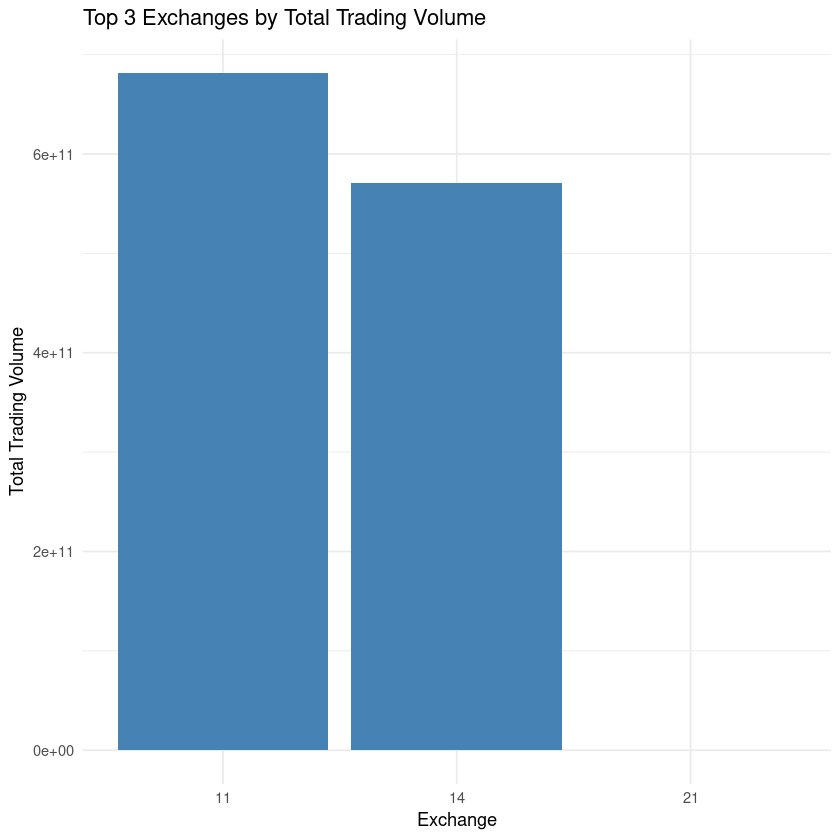

In [9]:
# visualize previous table in bar plot
ggplot(top_3_exchanges, aes(x = as.factor(exchg), y = total_volume)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(title = "Top 3 Exchanges by Total Trading Volume",
             x = "Exchange",
             y = "Total Trading Volume") +
    theme_minimal()

In [10]:
# number of companies have more than one ticker
ticker_counts <- data %>%
  group_by(conm) %>%
  summarize(ticker_count = n_distinct(tic)) %>%
  filter(ticker_count > 1)
print(ticker_counts)

# A tibble: 3 × 2
  conm         ticker_count
  <chr>               <int>
1 ALPHABET INC            2
2 FOX CORP                2
3 NEWS CORP               2


In [11]:
# ticker has the largest positive mean return
mean_returns <- data %>%
  group_by(tic) %>%
  mutate(ret = (prccd - lag(prccd)) / lag(prccd)) %>%
  summarize(mean_return = mean(ret, na.rm = TRUE)) %>%
  arrange(desc(mean_return)) %>%
  slice_head(n = 1)
print(mean_returns)

# A tibble: 1 × 2
  tic   mean_return
  <chr>       <dbl>
1 PLTR      0.00579


In [12]:
# company has the largest positive mean return
mean_returns_company <- data %>%
  group_by(conm) %>%
  mutate(ret = (prccd - lag(prccd)) / lag(prccd)) %>%
  summarize(mean_return = mean(ret, na.rm = TRUE)) %>%
  arrange(desc(mean_return)) %>%
  slice_head(n = 1)
print(mean_returns_company)

# A tibble: 1 × 2
  conm                   mean_return
  <chr>                        <dbl>
1 PALANTIR TECHNOLOG INC     0.00579


In [13]:
# industry represented by the most companies
industry_counts <- data %>%
  group_by(sic) %>%
  summarize(company_count = n_distinct(conm)) %>%
  arrange(desc(company_count)) %>%
  slice_head(n = 1)
print(industry_counts)

# A tibble: 1 × 2
    sic company_count
  <int>         <int>
1  6798            28


## A2_Analysis

In [14]:
# Calculate simple weekly returns for each ticker in the full dataset
weekly_returns <- data %>%
  mutate(datadate = as.Date(datadate, format = "%d/%m/%Y")) %>%
  group_by(tic) %>%
  arrange(datadate) %>%
  mutate(Week = floor_date(datadate, unit = "week")) %>%
  group_by(tic, Week) %>%
  summarise(Weekly_Close = last(prccd)) %>%
  arrange(tic, Week) %>%
  mutate(Weekly_Return = (Weekly_Close / lag(Weekly_Close)) - 1) %>%
  ungroup()

`summarise()` has grouped output by 'tic'. You can override using the `.groups`
argument.


In [15]:
# Categorise your data into decile groups based on simple weekly returns, labelled 0%, 10%, 20%, without removing zeroes
quantile_result <- weekly_returns %>%
  mutate(
    deciles = cut(
      Weekly_Return,
      breaks = quantile(
        Weekly_Return,
        probs = c(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        type = 5,
        na.rm = TRUE
      ),
      include.lowest = TRUE,
      labels = c("0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%")
    )
  )

In [16]:
head(quantile_result)

tic,Week,Weekly_Close,Weekly_Return,deciles
<chr>,<date>,<dbl>,<dbl>,<fct>
A,2023-01-01,147.67,NA,NA
A,2023-01-08,156.92,0.062639670,90%
A,2023-01-15,155.92,-0.006372674,30%
A,2023-01-22,155.69,-0.001475115,40%
A,2023-01-29,154.55,-0.007322243,30%
A,2023-02-05,152.55,-0.012940796,30%


In [17]:
# Display a table showing the top ticker (the ticker with the highest weekly return) in each decile group
top_tickers <- quantile_result %>%
  group_by(deciles) %>%
  filter(Weekly_Return == max(Weekly_Return)) %>%
  select(deciles, tic, Weekly_Return) %>%
  arrange(deciles)
print(top_tickers)

# A tibble: 12 × 3
# Groups:   deciles [10]
   deciles tic   Weekly_Return
   <fct>   <chr>         <dbl>
 1 0%      DVN        -0.0415 
 2 10%     WBD        -0.0248 
 3 20%     CNC        -0.0141 
 4 20%     TRMB       -0.0141 
 5 30%     GLW        -0.00544
 6 30%     PPL        -0.00544
 7 40%     AXP         0.00228
 8 50%     AZO         0.0101 
 9 60%     WDC         0.0185 
10 70%     PPG         0.0292 
11 80%     SJM         0.0470 
12 90%     SMCI        0.784  


In [18]:
# Select the top ticker from the 60% decile group.
top_60_ticker <- top_tickers %>%
  filter(deciles == "60%")
print(top_60_ticker$tic)

[1] "WDC"


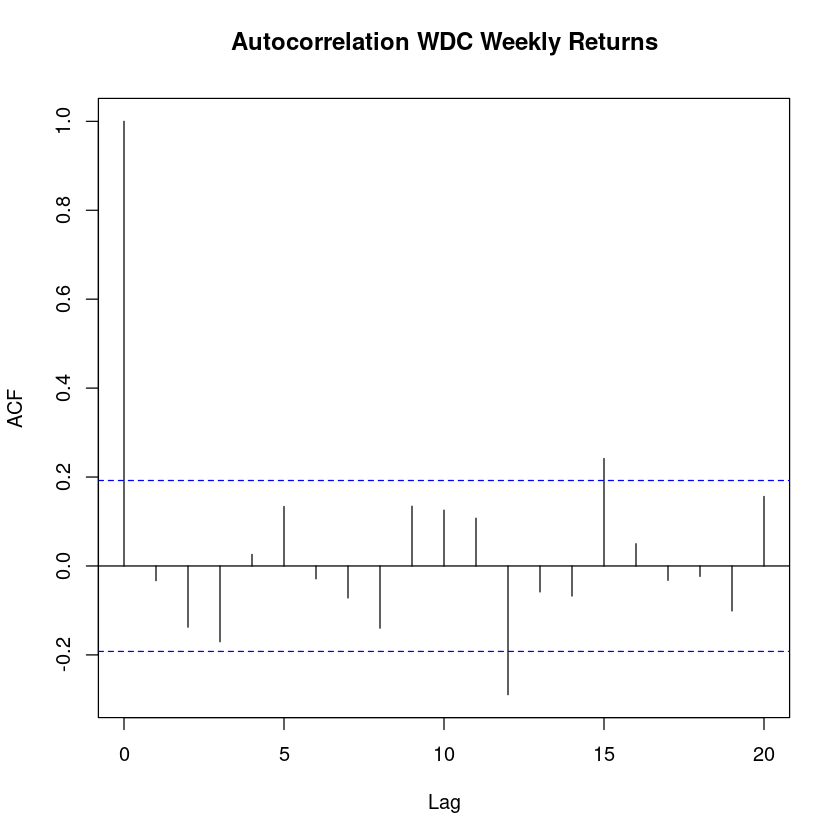

In [19]:
wdc_data <- weekly_returns %>%
  filter(tic == "WDC") %>%
  na.omit()

# Autocorrelate, add a main title
acf(wdc_data$Weekly_Return, main = "Autocorrelation WDC Weekly Returns")

## A2_Regression

In [20]:
# Load and clean the weekly Fama-French 3 factor data in fama_french_weekly. csv.
fama_french_data <- read.csv("fama_french_weekly.csv", skip=4)

In [21]:
fama_french_data$datadate <- as.Date(as.character(fama_french_data$X), format="%Y%m%d")
fama_french_data <- select(fama_french_data, datadate, Mkt.RF, SMB, HML, RF)

In [22]:
# for each column except datadate, divided by 100 to convert to decimal format
fama_french_data <- fama_french_data %>%
  mutate(across(-datadate, ~ . / 100))

In [ ]:
fama_french_data %>%
    filter(datadate >= as.Date("2023-01-01")) %>%
    slice(1)

datadate,Mkt.RF,SMB,HML,RF
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-06,0.0137,0.0027,0.0125,9e-04


In [52]:
rearrange_wdc_data <- data %>%
  filter(tic == "WDC") %>%
  mutate(datadate = as.Date(datadate, format = "%d/%m/%Y")) %>%
  arrange(datadate)

In [53]:
# calculate the weekly returns for WDC and make sure the datadate is aligned with Fama-French data
rearrange_wdc_data <- rearrange_wdc_data %>%
  mutate(Week = floor_date(datadate, unit = "week", week_start = 5)) %>%
  group_by(Week) %>%
  summarise(Weekly_Close = last(prccd)) %>%
  arrange(Week) %>%
  mutate(Weekly_Return = (Weekly_Close / lag(Weekly_Close)) - 1) %>%
  na.omit()

In [54]:
head(rearrange_wdc_data)

Week,Weekly_Close,Weekly_Return
<date>,<dbl>,<dbl>
2023-01-06,37.96,0.07749077
2023-01-13,37.55,-0.01080084
2023-01-20,43.76,0.16537949
2023-01-27,44.58,0.01873857
2023-02-03,41.99,-0.05809780
2023-02-10,42.57,0.01381281


In [57]:
merged_data <- merge(rearrange_wdc_data, fama_french_data, by.x = "Week", by.y = "datadate")  

In [59]:
head(merged_data)

,Week,Weekly_Close,Weekly_Return,Mkt.RF,SMB,HML,RF
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2023-01-06,37.96,0.07749077,0.0137,0.0027,0.0125,9e-04
2,2023-01-13,37.55,-0.01080084,0.0302,0.0337,-0.0324,9e-04
3,2023-01-20,43.76,0.16537949,-0.0069,0.0012,-0.0115,9e-04
4,2023-01-27,44.58,0.01873857,0.0257,-0.0009,-0.0122,9e-04
5,2023-02-03,41.99,-0.05809780,0.0181,0.0354,-0.0199,9e-04
6,2023-02-10,42.57,0.01381281,-0.0149,-0.0320,0.0266,9e-04


In [60]:
# calculate excess returns
merged_data <- merged_data %>%
  mutate(Excess_Return = Weekly_Return - Mkt.RF)

In [62]:
# use lm() to run a regression of WDC weekly returns on the three Fama-French factors
model <- lm(Excess_Return ~ Mkt.RF + SMB + HML, data = merged_data)
summary(model)


Call:
lm(formula = Excess_Return ~ Mkt.RF + SMB + HML, data = merged_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.104587 -0.039349 -0.007432  0.029993  0.185447 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.004220   0.005785   0.729   0.4675  
Mkt.RF      -0.663483   0.334330  -1.985   0.0500 *
SMB         -0.725547   0.378969  -1.915   0.0585 .
HML          0.077289   0.337305   0.229   0.8192  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05656 on 98 degrees of freedom
Multiple R-squared:  0.122,	Adjusted R-squared:  0.09517 
F-statistic: 4.541 on 3 and 98 DF,  p-value: 0.005043
